# Traditional Methods
- re-hashing the analysis that I did around fall 2020

In [92]:
import xarray as xr
from NI_tools.NI_tools import inversion, utils
from dask.distributed import Client
import hvplot.xarray
from scipy import signal
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['CMU Serif']
plt.rcParams.update({'font.size': 18})
plt.rc('axes', unicode_minus=False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35005,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:43213,Total threads: 4
Dashboard: http://127.0.0.1:45355/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:40737,


### write to netCDF to zarr

In [3]:
fn = '/datadrive/NCCFs/old/6year_NCCF_201_hilbert.nc'
NCCFs_201 = xr.open_dataarray(fn)
#NCCFs_201 = NCCFs_201.chunk({'delay':11999, 'dates':20})

fn = '/datadrive/NCCFs/old/6year_NCCF_601_hilbert.nc'
NCCFs_601 = xr.open_dataarray(fn)
#NCCFs_601 = NCCFs_601.chunk({'delay':11999, 'dates':20})

fn = '/datadrive/NCCFs/old/6year_NCCF_1001_hilbert.nc'
NCCFs_1001 = xr.open_dataarray(fn)
#NCCFs_1001 = NCCFs_1001.chunk({'delay':11999, 'dates':20})

In [4]:
NCCFs = xr.Dataset({'201':NCCFs_201, '601':NCCFs_601, '1001':NCCFs_1001})

In [5]:
NCCFs = NCCFs.chunk({'delay':119999, 'dates':20})

In [6]:
# write to zarr
NCCFs.to_zarr('/datadrive/NCCFs/old/6year_NCCF_hilbert.zarr')

## Compute Dense Arrival Times for 3 averaging times

### Broadband

In [7]:
ds = xr.open_zarr('/datadrive/NCCFs/old/6year_NCCF_hilbert.zarr/')

In [8]:
for item in ds.keys():
    print(item)

1001
201
601


In [9]:
arrival_times = inversion.calc_prop_times(ds, peaks=['dA', 's1b0A', 's1b0B', 's2b1A', 's2b1B'])

In [11]:
arrival_times.to_netcdf('/datadrive/NCCFs/old/arrival_times.nc')

### 40 Hz Cutoff

In [4]:
ds = xr.open_zarr('/datadrive/NCCFs/old/6year_NCCF_hilbert.zarr/')

In [10]:
b,a = signal.butter(4, Wn=0.4, btype='lowpass')
ds_filt = utils.xr_filtfilt(ds, dim='delay', b=b, a=a)

In [12]:
arrival_times = inversion.calc_prop_times(ds_filt, peaks=['dA', 's1b0A', 's1b0B', 's2b1A', 's2b1B'])

In [15]:
arrival_times.to_netcdf('/datadrive/NCCFs/old/arrival_times_1_40Hz.nc')

### Explore Arrival Times

#### Open Surface Temp

In [61]:
fn = '/datadrive/sst_data/*.nc'
ds = xr.open_mfdataset(fn)

lat_midpoint = 45.94718
lon_midpoint = 360-129.9913

lat_idx = np.argmin(np.abs(ds.lat.values - lat_midpoint))
lon_idx = np.argmin(np.abs(ds.lon.values - lon_midpoint))

surf_temp = ds.isel({'lat':lat_idx, 'lon':lon_idx}).sst.loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2021-01-01'):3]

In [66]:
temp_plot = surf_temp.hvplot(grid=True, height=200)

#### Plot arrival times

In [57]:
arrival_times_40 = xr.open_dataset('/datadrive/NCCFs/old/arrival_times_1_40Hz.nc')
arrival_times = xr.open_dataset('/datadrive/NCCFs/old/arrival_times.nc')

In [22]:
s1b0A_40 = arrival_times_40.loc[{'peak':'s1b0A'}].isel({'dates':slice(0,-1,50)})*-1
s1b0B_40 = arrival_times_40.loc[{'peak':'s1b0B'}].isel({'dates':slice(0,-1,50)})

s1b0A_bb = arrival_times.loc[{'peak':'s1b0A'}].isel({'dates':slice(0,-1,50)})*-1
s1b0B_bb = arrival_times.loc[{'peak':'s1b0B'}].isel({'dates':slice(0,-1,50)})

In [70]:
avg_hr = '201'
arr_plot_201 = (s1b0A_40[avg_hr].hvplot(label='40 Hz',grid=True, title=f'{avg_hr} hours averaging', ylabel='arrival time [s]', ylim=(2.985, 2.991)) * s1b0A_bb[avg_hr].hvplot(label='broad band'))

In [68]:
avg_hr = '601'
arr_plot_601 = (s1b0A_40[avg_hr].hvplot(label='40 Hz',grid=True, title=f'{avg_hr} hours averaging', ylabel='arrival time [s]', ylim=(2.985, 2.991)) * s1b0A_bb[avg_hr].hvplot(label='broad band'))

In [69]:
avg_hr = '1001'
arr_plot_1001 = (s1b0A_40[avg_hr].hvplot(label='40 Hz',grid=True, title=f'{avg_hr} hours averaging', ylabel='arrival time [s]', ylim=(2.985, 2.991)) * s1b0A_bb[avg_hr].hvplot(label='broad band'))

In [71]:
(arr_plot_201 + temp_plot).cols(1)

:Layout
   .Overlay.I :Overlay
      .Curve.A_40_Hz    :Curve   [dates]   (201)
      .Curve.Broad_band :Curve   [dates]   (201)
   .Curve.I   :Curve   [time]   (sst)

In [72]:
(arr_plot_601 + temp_plot).cols(1)

:Layout
   .Overlay.I :Overlay
      .Curve.A_40_Hz    :Curve   [dates]   (601)
      .Curve.Broad_band :Curve   [dates]   (601)
   .Curve.I   :Curve   [time]   (sst)

In [75]:
arr_plot_1001 * temp_plot

:Overlay
   .Curve.A_40_Hz    :Curve   [dates]   (1001)
   .Curve.Broad_band :Curve   [dates]   (1001)
   .Curve.I          :Curve   [time]   (sst)

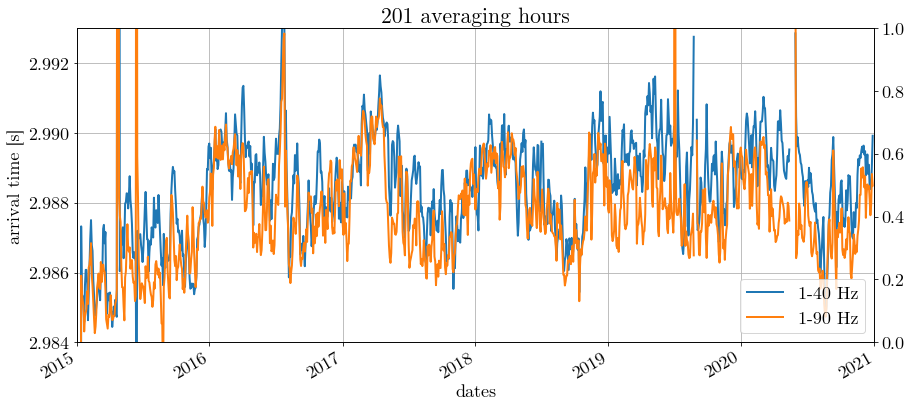

In [138]:
avg_hr = '201'

fig, ax1 = plt.subplots(figsize=(13,6))
ax2 = ax1.twinx()

#plt.sca(ax2)
#surf_temp.plot(c='k', label='temperature')
#ax2.invert_yaxis()
#plt.title('')
#plt.legend()
#plt.ylabel('surface temperature [°C]')

plt.sca(ax1)
s1b0A_40[avg_hr].plot(linewidth=2, label='1-40 Hz')
s1b0A_bb[avg_hr].plot(linewidth=2, label='1-90 Hz')
plt.ylim([2.984, 2.993])
plt.grid()
plt.legend(loc='lower right', facecolor='white',)
plt.title(avg_hr + ' averaging hours')
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2021-01-01')])
plt.ylabel('arrival time [s]')


plt.tight_layout()

fig.savefig(f'figures/{avg_hr}_arrival_time.png', dpi=300)